# Hospital Readmissions Data Analysis and Recommendations for Reduction

### Background
In October 2012, the US government's Center for Medicare and Medicaid Services (CMS) began reducing Medicare payments for Inpatient Prospective Payment System hospitals with excess readmissions. Excess readmissions are measured by a ratio, by dividing a hospital’s number of “predicted” 30-day readmissions for heart attack, heart failure, and pneumonia by the number that would be “expected,” based on an average hospital with similar patients. A ratio greater than 1 indicates excess readmissions.

### Exercise Directions

In this exercise, you will:
+ critique a preliminary analysis of readmissions data and recommendations (provided below) for reducing the readmissions rate
+ construct a statistically sound analysis and make recommendations of your own 

More instructions provided below. Include your work **in this notebook and submit to your Github account**. 

### Resources
+ Data source: https://data.medicare.gov/Hospital-Compare/Hospital-Readmission-Reduction/9n3s-kdb3
+ More information: http://www.cms.gov/Medicare/medicare-fee-for-service-payment/acuteinpatientPPS/readmissions-reduction-program.html
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
****

In [11]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bokeh.plotting as bkp
from mpl_toolkits.axes_grid1 import make_axes_locatable
import random
import math
import seaborn as sns
import scipy
from scipy import stats
import pylab
from code.bootstrap_routines import *
from scipy.stats import mannwhitneyu
%matplotlib inline


In [12]:
# read in readmissions data provided

hospital_read_df = pd.read_csv('/Users/chintan.desai/Documents/Chintan/DataScience/Springboard/Mini_Projects/hospital_readmit/data/cms_hospital_readmissions.csv')


 

In [5]:
hospital_read_df.head()

,Hospital Name,Provider Number,State,Measure Name,Number of Discharges,Footnote,Excess Readmission Ratio,Predicted Readmission Rate,Expected Readmission Rate,Number of Readmissions,Start Date,End Date
0,FROEDTERT MEMORIAL LUTHERAN HOSPITAL,520177,WI,READM-30-HIP-KNEE-HRRP,242,NaN,1.9095,10.8,5.6,38.0,07/01/2010,06/30/2013
1,PROVIDENCE HOSPITAL,90006,DC,READM-30-HIP-KNEE-HRRP,247,NaN,1.7521,9.2,5.3,33.0,07/01/2010,06/30/2013
2,BEAUFORT COUNTY MEMORIAL HOSPITAL,420067,SC,READM-30-HIP-KNEE-HRRP,586,NaN,1.5836,7.6,4.8,53.0,07/01/2010,06/30/2013
3,ADVOCATE CHRIST HOSPITAL & MEDICAL CENTER,140208,IL,READM-30-HIP-KNEE-HRRP,965,NaN,1.5760,9.0,5.7,95.0,07/01/2010,06/30/2013
4,BRAZOSPORT REGIONAL HEALTH SYSTEM,450072,TX,READM-30-HIP-KNEE-HRRP,149,NaN,1.5308,8.2,5.4,20.0,07/01/2010,06/30/2013


In [28]:
hospital_read_df.describe()

,Provider Number,Footnote,Excess Readmission Ratio,Predicted Readmission Rate,Expected Readmission Rate,Number of Readmissions
count,16860.000000,3129.000000,13731.000000,13731.000000,13731.000000,11497.000000
mean,263516.943654,2.905401,1.002582,16.916532,16.866135,63.633731
std,160146.191702,2.074384,0.091088,6.197542,5.989652,59.540296
min,10001.000000,1.000000,0.549500,2.700000,2.900000,11.000000
25%,110181.500000,1.000000,0.949500,15.200000,15.800000,24.000000
50%,250157.000000,1.000000,0.997100,18.500000,18.500000,45.000000
75%,390138.250000,5.000000,1.052350,21.100000,21.100000,82.000000
max,670091.000000,7.000000,1.909500,32.800000,29.400000,879.000000


****
## Preliminary Analysis

In [94]:
#selecting Quartile range to see what are the most common values

print(hospital_read_df[['Excess Readmission Ratio','Number of Readmissions']].quantile([0.05,0.95]))

      Excess Readmission Ratio  Number of Readmissions
0.05                    0.8659                    13.0
0.95                    1.1506                   175.0


In [25]:
list(hospital_read_df.columns.values)

['Hospital Name',
 'Provider Number',
 'State',
 'Measure Name',
 'Number of Discharges',
 'Footnote',
 'Excess Readmission Ratio',
 'Predicted Readmission Rate',
 'Expected Readmission Rate',
 'Number of Readmissions',
 'Start Date',
 'End Date']

In [12]:
pj = hospital_read_df['Excess Readmission Ratio']
pj.isnull().values.any()

True

In [13]:
pf = hospital_read_df['Number of Discharges']
pf.isnull().values.any()


False

In [11]:


pf = hospital_read_df.groupby('Number of Discharges').count()
pf.loc[['Not Available'],['Hospital Name']]


,Hospital Name
Number of Discharges,
Not Available,5282


In [13]:
# deal with missing and inconvenient portions of data

#filter out the 5282 rows where the value of 'number of Discharges' is 'Not Available'
clean_hospital_read_df = hospital_read_df[hospital_read_df['Number of Discharges'] != 'Not Available']

#Convert 'Number of Discharges' from Text to Int
#All rows for column 'Number of Discharges'
clean_hospital_read_df.loc[:, 'Number of Discharges'] = clean_hospital_read_df['Number of Discharges'].astype(int)
#clean_hospital_read_df['Number of Discharges'] = clean_hospital_read_df['Number of Discharges'].astype(int)
clean_hospital_read_df = clean_hospital_read_df.sort_values('Number of Discharges')

//anaconda/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


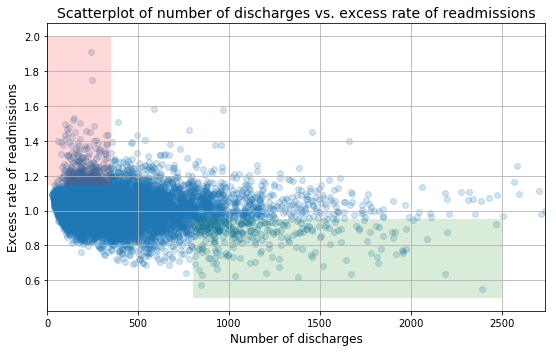

In [30]:
# generate a scatterplot for number of discharges vs. excess rate of readmissions
# lists work better with matplotlib scatterplot function
x = [a for a in clean_hospital_read_df['Number of Discharges'][81:-3]]
y = list(clean_hospital_read_df['Excess Readmission Ratio'][81:-3])

fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(x, y,alpha=0.2)

ax.fill_between([0,350], 1.15, 2, facecolor='red', alpha = .15, interpolate=True)
ax.fill_between([800,2500], .5, .95, facecolor='green', alpha = .15, interpolate=True)

ax.set_xlim([0, max(x)])
ax.set_xlabel('Number of discharges', fontsize=12)
ax.set_ylabel('Excess rate of readmissions', fontsize=12)
ax.set_title('Scatterplot of number of discharges vs. excess rate of readmissions', fontsize=14)

ax.grid(True)
fig.tight_layout()

In [35]:
clean_hospital_read_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11578 entries, 16857 to 13666
Data columns (total 12 columns):
Hospital Name                 11578 non-null object
Provider Number               11578 non-null int64
State                         11578 non-null object
Measure Name                  11578 non-null object
Number of Discharges          11578 non-null int64
Footnote                      81 non-null float64
Excess Readmission Ratio      11497 non-null float64
Predicted Readmission Rate    11497 non-null float64
Expected Readmission Rate     11497 non-null float64
Number of Readmissions        11497 non-null float64
Start Date                    11578 non-null object
End Date                      11578 non-null object
dtypes: float64(5), int64(2), object(5)
memory usage: 1.1+ MB


In [9]:
clean_hospital_read_df.describe()

,Provider Number,Number of Discharges,Footnote,Excess Readmission Ratio,Predicted Readmission Rate,Expected Readmission Rate,Number of Readmissions
count,11578.000000,11578.000000,81.0,11497.000000,11497.000000,11497.000000,11497.000000
mean,257681.537226,362.909397,7.0,1.007504,17.984292,17.865695,63.633731
std,154542.645531,309.176945,0.0,0.091964,5.487651,5.240749,59.540296
min,10001.000000,0.000000,7.0,0.549500,2.700000,3.900000,11.000000
25%,110129.750000,157.000000,7.0,0.952600,16.300000,16.600000,24.000000
50%,250040.000000,280.000000,7.0,1.003500,19.000000,19.000000,45.000000
75%,390041.000000,472.750000,7.0,1.058100,21.500000,21.400000,82.000000
max,670082.000000,6793.000000,7.0,1.909500,32.800000,28.000000,879.000000


****

## Preliminary Report

Read the following results/report. While you are reading it, think about if the conclusions are correct, incorrect, misleading or unfounded. Think about what you would change or what additional analyses you would perform.

**A. Initial observations based on the plot above**
+ Overall, rate of readmissions is trending down with increasing number of discharges
+ With lower number of discharges, there is a greater incidence of excess rate of readmissions (area shaded red)
+ With higher number of discharges, there is a greater incidence of lower rates of readmissions (area shaded green) 

**B. Statistics**
+ In hospitals/facilities with number of discharges < 100, mean excess readmission rate is 1.023 and 63% have excess readmission rate greater than 1 
+ In hospitals/facilities with number of discharges > 1000, mean excess readmission rate is 0.978 and 44% have excess readmission rate greater than 1 

**C. Conclusions**
+ There is a significant correlation between hospital capacity (number of discharges) and readmission rates. 
+ Smaller hospitals/facilities may be lacking necessary resources to ensure quality care and prevent complications that lead to readmissions.

**D. Regulatory policy recommendations**
+ Hospitals/facilties with small capacity (< 300) should be required to demonstrate upgraded resource allocation for quality care to continue operation.
+ Directives and incentives should be provided for consolidation of hospitals and facilities to have a smaller number of them with higher capacity and number of discharges.

****
### Exercise

Include your work on the following **in this notebook and submit to your Github account**. 

A. Do you agree with the above analysis and recommendations? Why or why not?
   
B. Provide support for your arguments and your own recommendations with a statistically sound analysis:

   1. Setup an appropriate hypothesis test.
   2. Compute and report the observed significance value (or p-value).
   3. Report statistical significance for $\alpha$ = .01. 
   4. Discuss statistical significance and practical significance. Do they differ here? How does this change your recommendation to the client?
   5. Look at the scatterplot above. 
      - What are the advantages and disadvantages of using this plot to convey information?
      - Construct another plot that conveys the same information in a more direct manner.



You can compose in notebook cells using Markdown: 
+ In the control panel at the top, choose Cell > Cell Type > Markdown
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
****

#Check if there is a relationship between Number of Discharges and Excess Readmission Ratio


*Lets Check the distribution of the two variables 
    *Number of Discharges
    *Excess Readmission Ratio
    


In [14]:
clean_hospital_read_df=clean_hospital_read_df[clean_hospital_read_df['Number of Readmissions'].notnull()]
clean_hospital_read_df['Number of Readmissions'].count()

11497

In [15]:
clean_hospital_read_df['Number of Discharges'].count()

11497

In [16]:
clean_hospital_read_df['Number of Discharges']=pd.to_numeric(clean_hospital_read_df['Number of Discharges'])
clean_hospital_read_df['Number of Discharges'].count()

11497

In [12]:
clean_hospital_read_df.describe()

,Provider Number,Number of Discharges,Footnote,Excess Readmission Ratio,Predicted Readmission Rate,Expected Readmission Rate,Number of Readmissions
count,11497.000000,11497.000000,0.0,11497.000000,11497.000000,11497.000000,11497.000000
mean,257571.540141,365.466209,NaN,1.007504,17.984292,17.865695,63.633731
std,154274.374018,308.754590,NaN,0.091964,5.487651,5.240749,59.540296
min,10001.000000,25.000000,NaN,0.549500,2.700000,3.900000,11.000000
25%,110129.000000,160.000000,NaN,0.952600,16.300000,16.600000,24.000000
50%,250042.000000,282.000000,NaN,1.003500,19.000000,19.000000,45.000000
75%,390039.000000,474.000000,NaN,1.058100,21.500000,21.400000,82.000000
max,670082.000000,6793.000000,NaN,1.909500,32.800000,28.000000,879.000000


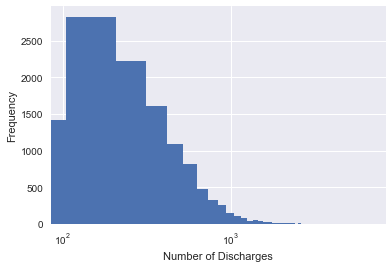

In [31]:
ax = clean_hospital_read_df['Number of Discharges'].plot(kind='hist', bins=65)
ax.set_xlabel("Number of Discharges")
ax.set_xscale('log')

#check log scale ax.set_scale(ax,'log')

#parametric - mean , std.deviation
#mean=median , for normal distribution

#non-parametric statistical test, H0 : comparing bars in two distribution
#comparing two distribution , mann-whitney
#you can use boostrap

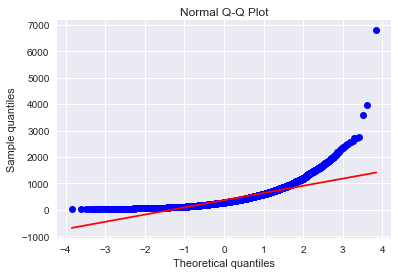

In [15]:
stats.probplot(clean_hospital_read_df['Number of Discharges'], dist="norm", plot=pylab)
pylab.title("Normal Q-Q Plot")
pylab.ylabel("Sample quantiles")
pylab.show()

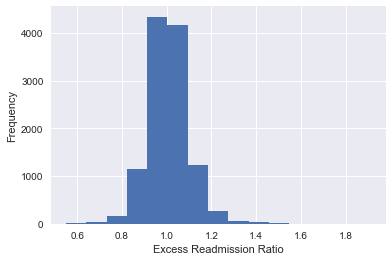

In [58]:
ax = clean_hospital_read_df['Excess Readmission Ratio'].plot(kind='hist', bins=15)
ax.set_xlabel("Excess Readmission Ratio")

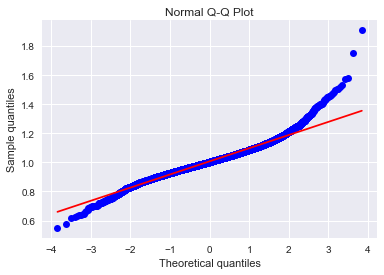

In [16]:
stats.probplot(clean_hospital_read_df['Excess Readmission Ratio'], dist="norm", plot=pylab)
pylab.title("Normal Q-Q Plot")
pylab.ylabel("Sample quantiles")
pylab.show()

#### Checking for Normal Distribution.

Our null hypothesis H0=Number of Discharges Normally distributed

Our alternate hypothesis Ha=Number of Discharges is Not Normally distributed

In [44]:
numofdischarg = clean_hospital_read_df['Number of Discharges']

shapiro_results = scipy.stats.shapiro(numofdischarg)

print('Shapiro Results'+' P-Value = ' + str(shapiro_results[1]) + '  Test-Statistic  =' + str(shapiro_results[0]))

z,pval = stats.normaltest(numofdischarg)

print('Normal test Results'+' P-Value = ' + str(pval) + '  z  =' + str(z))

Shapiro Results P-Value = 0.0  Test-Statistic  =0.7770348191261292
Normal test Results P-Value = 0.0  z  =8398.63010845


//anaconda/envs/py36/lib/python3.6/site-packages/scipy/stats/morestats.py:1326: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


#### As shown above we have warrning on the P-Value to determine if the data follows a normal distribution or not ,so to avoid this we will just take random sample out of the original data set for 5000 samples

In [19]:
numofdischarg = clean_hospital_read_df['Number of Discharges']
numofdischargesample = np.random.choice(numofdischarg,size=4000)


shapiro_results = scipy.stats.shapiro(numofdischargesample)

print('Shapiro Results'+' P-Value = ' + str(shapiro_results[1]) + '  Test-Statistic  =' + str(shapiro_results[0]))

z,pval = stats.normaltest(numofdischargesample)

print('Normal test Results'+' P-Value = ' + str(pval) + '  z  =' + str(z))


Shapiro Results P-Value = 0.0  Test-Statistic  =0.8032371401786804
Normal test Results P-Value = 0.0  z  =1909.59573369


#### The Shapiro Test and Normal Test yields the P-Value < 0.05 , so we can reject the null hypothesis and go with the alternate hypothesis that the 'Number of Discharges' does not follow the Normal Distribution


#### Checking for Normal Distribution.
Our null hypothesis H0=Excess Readmission Ratio Normally distributed

Our alternate hypothesis Ha=Excess Readmission Ratio is Not Normally distributed

In [17]:
excessreadmin = clean_hospital_read_df['Excess Readmission Ratio']

shapiro_results = scipy.stats.shapiro(excessreadmin)

print('Shapiro Results'+' P-Value = ' + str(shapiro_results[1]) + '  Test-Statistic  =' + str(shapiro_results[0]))

z,pval = stats.normaltest(excessreadmin)

print('Normal test Results'+' P-Value = ' + str(pval) + '  z  =' + str(z))

Shapiro Results P-Value = 4.203895392974451e-45  Test-Statistic  =0.966856837272644
Normal test Results P-Value = 0.0  z  =1531.40376748


//anaconda/envs/py36/lib/python3.6/site-packages/scipy/stats/morestats.py:1326: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


#### As shown above we have warrning on the P-Value to determine if the data follows a normal distribution or not ,so to avoid this we will just take random sample out of the original data set for 5000 samples

In [44]:
clean_hospital_read_df['Excess Readmission Ratio'].describe()

count    11497.000000
mean         1.007504
std          0.091964
min          0.549500
25%          0.952600
50%          1.003500
75%          1.058100
max          1.909500
Name: Excess Readmission Ratio, dtype: float64

In [18]:

excessreadmin = clean_hospital_read_df['Excess Readmission Ratio']
excessreadminsample = np.random.choice(excessreadmin,size=4000)

shapiro_results = scipy.stats.shapiro(excessreadminsample)

print('Shapiro Results'+' P-Value = ' + str(shapiro_results[1]) + '  Test-Statistic  =' + str(shapiro_results[0]))

z,pval = stats.normaltest(excessreadminsample)

print('Normal test Results'+' P-Value = ' + str(pval) + '  z  =' + str(z))

Shapiro Results P-Value = 1.5262235270647026e-28  Test-Statistic  =0.9690449237823486
Normal test Results P-Value = 2.94312889517e-112  z  =513.6201143


#### The Shapiro Test and Normal Test yields the P-Value < 0.05 , so we can reject the null hypothesis and go with the alternate hypothesis that the 'Excess Readmission Ratio' does not follow the Normal Distribution

### Q1. Setup an appropriate hypothesis test

 
   

#### Q1.1 > Next we Need to conduct Hypothesis test to see if the mean of 'Number of Discharges' and 'Excess Readmission Ratio' is same or not.
#### This will help us determine if the distribution of these two variables is same or not.
#### We also calculate the following
    Q1.1.1. Compute and report the observed significance value (or p-value).
    Q1.1.2. Report statistical significance for $\alpha$ = .01. 


Our null hypothesis H0=(Mean of 'Number of Discharges' - mean of 'Excess Readmission Ratio' = 0) (in other words :There is no relationship between these two variables)

Our null hypothesis Ha=(Mean of 'Number of Discharges' - Mean of 'Excess Readmission Ratio' > 0) (in other words :There is relationship between these two variables)
                       

#### Note that we are not able to conclude that the 'Number of Discharges' and 'Excess Readmission Ratio' follows normal distribution and hence CLT does not apply and so we can use the T-Test or Z-Test. Thus we wil use Bootstrap Test to check if the difference in mean between these two variables

In [23]:
p_val = bootpv(clean_hospital_read_df['Number of Discharges'],clean_hospital_read_df['Excess Readmission Ratio'])

print('p_val = ',p_val)

Observed difference of two means: 364.46
0 out of 10000 experiments had a difference of two means greater than or equal to 364.46
The chance of getting a difference of two means greater than or equal to 364.46 is 0.0000
p_val =  0.0


#### Based on the fact that the P_Value < 0.05 as well as P_Value < 0.01 , we can reject the Null hypothesis and can say that There is relationship between these two variables  

#### Q1.2 > Next we Need to conduct Man-Whitney-U test to see if the median of 'Number of Discharges' and 'Excess Readmission Ratio' is same or not.
#### This will help us determine if the distribution of these two variables is same or not.
#### We also calculate the following
    Q1.2.1. Compute and report the observed significance value (or p-value).
    Q1.2.2. Report statistical significance for $\alpha$ = .01. 


H0 : There is no statistically significant difference between the median of 'Number of Discharges' and median of 'Excess readmission ratio'.

Ha : There is statistically significant difference between the median of 'Number of Discharges' and median of 'Excess readmission ratio'.

In [9]:
mannwhitneyu(clean_hospital_read_df['Number of Discharges'],clean_hospital_read_df['Excess Readmission Ratio'])

MannwhitneyuResult(statistic=0.0, pvalue=0.0)

Given that P_Value < 0.05 and < 0.01 we reject the null hypothesis and accept the alternate hypothesis that There is a statistically significant difference between the median of 'Number of Discharges' and median of 'Excess readmission ratio'. 

#### Q1.3> Next we conduct the Hypothesis test to find the correlation between these two variables
#### This will help us determine if there is correlation between these two variables  or not.
#### We also calculate the following
    Q1.3.1. Compute and report the observed significance value (or p-value).
    Q1.3.2. Report statistical significance for $\alpha$ = .01. 



##### H0 : No Significant correlation between Number of discharges and Excess Readmission Ratio
##### Ha : There is significant correlation between Number of discharges and Excess Readmission Ratio



In [58]:
clean_hospital_read_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11497 entries, 1832 to 13666
Data columns (total 12 columns):
Hospital Name                 11497 non-null object
Provider Number               11497 non-null int64
State                         11497 non-null object
Measure Name                  11497 non-null object
Number of Discharges          11497 non-null int64
Footnote                      0 non-null float64
Excess Readmission Ratio      11497 non-null float64
Predicted Readmission Rate    11497 non-null float64
Expected Readmission Rate     11497 non-null float64
Number of Readmissions        11497 non-null float64
Start Date                    11497 non-null object
End Date                      11497 non-null object
dtypes: float64(5), int64(2), object(5)
memory usage: 1.1+ MB


In [24]:
clean_hospital_read_df.corr()

,Provider Number,Number of Discharges,Footnote,Excess Readmission Ratio,Predicted Readmission Rate,Expected Readmission Rate,Number of Readmissions
Provider Number,1.000000,-0.009596,NaN,-0.012112,-0.009049,-0.003710,-0.009099
Number of Discharges,-0.009596,1.000000,NaN,-0.097398,-0.135163,-0.131091,0.791272
Footnote,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Excess Readmission Ratio,-0.012112,-0.097398,NaN,1.000000,0.200039,-0.031104,0.117600
Predicted Readmission Rate,-0.009049,-0.135163,NaN,0.200039,1.000000,0.965420,0.361033
Expected Readmission Rate,-0.003710,-0.131091,NaN,-0.031104,0.965420,1.000000,0.330527
Number of Readmissions,-0.009099,0.791272,NaN,0.117600,0.361033,0.330527,1.000000


r = -0.097398
n = 11497



In [16]:
r = -0.097398
n = 11497
df = n-2

tval=(r*(math.sqrt((n-2)/(1-r**2))))

print('T-Score = ',tval)


p_value = stats.t.sf(np.abs(tval), df)*2  # two-sided pvalue = Prob(abs(t)>tt)

print('P-Value = ',p_value)

T-Score =  -10.492386957113085
P-Value =  1.22246862341e-25


##### pvalue<0.05 so we can reject Ho and accept Ha

##### Ha: There is significant correlation between hospital capacity and excess readmission ratio.

### Q4. Discuss statistical significance and practical significance. Do they differ here? How does this change your recommendation to the client?

In [50]:
large_hospital = clean_hospital_read_df[clean_hospital_read_df['Number of Discharges'] > 1000]

#visual inspection to make sure it is bringing in the right data
large_hospital.head()

,Hospital Name,Provider Number,State,Measure Name,Number of Discharges,Footnote,Excess Readmission Ratio,Predicted Readmission Rate,Expected Readmission Rate,Number of Readmissions,Start Date,End Date
11757,FLETCHER ALLEN HOSPITAL OF VERMONT,470003,VT,READM-30-AMI-HRRP,1002,NaN,0.9192,14.0,15.2,136.0,07/01/2010,06/30/2013
821,CRITTENTON HOSPITAL MEDICAL CENTER,230254,MI,READM-30-HIP-KNEE-HRRP,1004,NaN,1.1405,6.1,5.4,64.0,07/01/2010,06/30/2013
2363,YUMA REGIONAL MEDICAL CENTER,30013,AZ,READM-30-PN-HRRP,1007,NaN,1.0760,18.5,17.2,191.0,07/01/2010,06/30/2013
7188,EVANSTON HOSPITAL,140010,IL,READM-30-COPD-HRRP,1007,NaN,0.9930,20.0,20.2,201.0,07/01/2010,06/30/2013
2341,KING'S DAUGHTERS' MEDICAL CENTER,180009,KY,READM-30-PN-HRRP,1008,NaN,1.0765,21.0,19.5,216.0,07/01/2010,06/30/2013


In [55]:
rows,colms = large_hospital.shape

num_of_largehospital = rows

print('number of hospitals with discharges > 1000 = ', num_of_largehospital)

number of hospitals with discharges > 1000 =  463


In [58]:
small_hospital = clean_hospital_read_df[clean_hospital_read_df['Number of Discharges'] < 100]

rowsmall,colmsmall = small_hospital.shape

num_of_smallhospital = rowsmall

print('number of hospitals with discharges < 100 = ', num_of_smallhospital)

number of hospitals with discharges < 100 =  1188


##### Statistical Significance : It means the effect observed in the sample was unlikely to have occured due to chance alone in other words it would be very unlikely to see what was observed in the sample if the null hypothesis is true.

 Sample Size directly affects the P-Value , the larger the sample size the smaller the p-value indicating the more likelyhood of  rejecting the null hypothesis , similarly the smaller the sample size the larger the P-value indicating more liklyhood of accpeting the null hypothesis.

##### Practical Significance : Does the result matter ?

Often the benchmark data is very useful to determine the practical significance for example 
  co-efficient between 0.24 and 0.35 - very significant
  co-efficient between 0.35 and 0.43 - medium significant
  co-efficient between 0.45 and 0.61 - no signifiance

one way to interprte the co-rrleation coefficient in terms of Practical significance is to calculate r2 which tells us  how much variability in one variable is explained by the other variable

Another way to determine the practical significnace is to calculate appropriate confidence interval, the interval illustrates the size of the effect and can help to determine if the effect has any practical signifiance.


##### Assesing the Practical Signifiance 

Based on the infomration discussed above it looks like we definately have a large sample size (11497) and so giving us more likelyhood of rejecting the null hypothesis for various statistical tests.

Here are two tests that we can perform to make sure we can check for practical significance:

1> We can also calculate the confidence interval of differnece in mean.  

2> We can calculate the r2 to check for the practical significance of the corrlation co-efficient




##### 1> Below we define the two population sets based on the 'Excess Readmission Ratio' for which we would want to calculate the difference in mean

In [17]:
dfa1=clean_hospital_read_df[clean_hospital_read_df['Excess Readmission Ratio']<=1]
dfa2=clean_hospital_read_df[clean_hospital_read_df['Excess Readmission Ratio']>1]

#Note that count() on a column of interest is more efficient then using shape on entire dataframe
#rowsdfa1,colmsdfa1 = dfa1.shape
#rowsdfa2,colmsdfa2 = dfa2.shape

rowsdfa1 = dfa1['Number of Discharges'].count()
rowsdfa2 = dfa2['Number of Discharges'].count()



print('rowsdfa1 = ', rowsdfa1)
print('rowsdfa2 = ', rowsdfa2)

rowsdfa1 =  5558
rowsdfa2 =  5939


H0: There is No significant difference between hospitals where (Mean of) "number of discharges" with exess readmission ratio <=1 and hospitals where (Mean of) "number of discharges" with excess readmission ratio>1

Ha: There is significant difference between hospitals where (Mean of) "number of discharges" with exess readmission ratio <=1 and hospitals where (Mean of) "number of discharges" with excess readmission ratio>1



In [27]:
meandfa1 = np.mean(dfa1['Number of Discharges'])
print('meandfa1 = ', meandfa1)

stddev1 = np.std(dfa1['Number of Discharges'])
print('stddev1 = ', stddev1)


meandfa1 =  381.2952500899604
stddev1 =  322.72492665207017


In [28]:
meandfa2 = np.mean(dfa2['Number of Discharges'])
print('meandfa2 = ', meandfa2)

stddev2 = np.std(dfa2['Number of Discharges'])
print('stddev2 = ', stddev2)


meandfa2 =  350.6526351237582
stddev2 =  294.28453436639086


In [71]:
stats.ttest_ind(dfa1['Number of Discharges'],dfa2['Number of Discharges'])

Ttest_indResult(statistic=5.3241711542009593, pvalue=1.0332472818989955e-07)

Since P_Value < 0; We can reject the null hypothesis and go with alternate hypothesis that there is significant difference between hospitals where (Mean of) "number of discharges" with exess readmission ratio <=1 and hospitals where (Mean of) "number of discharges" with excess readmission ratio>1

##### Calculating 95% Confidence interval for the difference of mean

confidence_interval = abs(mean1 - mean2) +- SE

Where SE: 

SE = sqrt[ (s1**2/n1) + (s2**2/n2) ]

In [81]:
s1 = stddev1
s2 = stddev2
n1 = rowsdfa1
n2 = rowsdfa2


moe_part = np.sqrt((s1**2/n1) + (s2**2/n2)) 

z = 1.96

margin_error = z * moe_part

print('margin_error = ',margin_error)




margin_error =  11.3139975254


In [84]:
diff_mean = abs(meandfa2 - meandfa1)

In [85]:
print('difference in mean = ',diff_mean)


difference in mean =  30.64261496620219


In [86]:
confidence_interval_lowerbound = diff_mean - margin_error

In [87]:
confidence_interval_upperbound = diff_mean + margin_error

In [88]:
print('Confidence Interval',confidence_interval_lowerbound,confidence_interval_upperbound)

Confidence Interval 19.3286174408 41.9566124916


#### Using the Bootstrap approach to calculate P_Value as well as 95% Confidence Interval

In [29]:
p_val = bootpv(dfa1['Number of Discharges'],dfa2['Number of Discharges'])



Observed difference of two means: 30.64
0 out of 10000 experiments had a difference of two means greater than or equal to 30.64
The chance of getting a difference of two means greater than or equal to 30.64 is 0.0000


0.0

In [31]:
ci_diff = bootci_diff(dfa1['Number of Discharges'],dfa2['Number of Discharges'])

blower_bound,bupper_bound = ci_diff

print('95% Confidence Interval = ',abs(blower_bound),abs(bupper_bound))

95% Confidence Interval =  19.2217920697 42.055037235


There is 95% confidence that this  difference in mean of "number discharges" between hospital with different 'Excess Readmission Ratio' is 19.23 to 42.05. 

As we can see above the Frequentist approach and Bootstrap approach pretty much is matching as far as validating the hypothesis and calculating the 95% confidence interval of difference in mean value between the two population.

#### 2> Calculating the R2 

##### As we have calculated above the corelation co-efficient between 'Number of Discharges' and 'Excess Readmission Ratio' is  r = -0.097398

In [31]:
r1 = -0.097398
r_square = r1 **2

r_square

0.009486370404

##### We conclude that 0.9 % of 'Excess Readmission Ratio' is related to 'Number of Discharges' which does not seem that significant meaning that there are other factors that may be relatd to 'Excess Readmission Ratio' more than the 'Number of Discharges'

## Q5B. Look at the scatterplot above. 
 ** What are the advantages and disadvantages of using this plot to convey information?**
 + Advantages: It has clear labels of axis titles and what it is all about
 + Disadvantages: It is difficult to see the difference or boundary of in the samples that have excess readmission ration <=1 and those>1. 
  
 **Construct another plot that conveys the same information in a more direct manner.**

As shown below we have a plot that focus on the number of discharges for Hospitals with ERR >= 1 as well as for Hospitals with ERR < 1

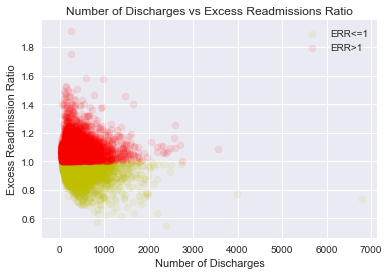

In [26]:
plt.scatter(dfa1['Number of Discharges'],dfa1['Excess Readmission Ratio'],c='y', label="ERR<=1", alpha=0.10)
plt.scatter(dfa2['Number of Discharges'],dfa2['Excess Readmission Ratio'], c='r', label='ERR>1', alpha=0.1)


plt.xlabel('Number of Discharges')
plt.ylabel('Excess Readmission Ratio')
plt.title('Number of Discharges vs Excess Readmissions Ratio')
plt.legend()